In [3]:
import sys
sys.path.append('../Automatic-Circuit-Discovery/')
sys.path.append('..')
import os
os.chdir("/root/acdcpp/docstring_task/")
import re
import json
import pandas as pd
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('seaborn-v0_8-paper')
mpl.rcParams['font.size'] = 50

device = t.device("cuda" if t.cuda.is_available() else "CPU")
print(device)

cuda


In [5]:
from acdc.docstring.utils import get_docstring_subgraph_true_edges

RUN_NAME = 'abs_edges'

# with open(f'acdc_edges_num_passes.json', 'r') as f:
#     num_passes = json.load(f)

with open(f'acdc_edges_acdc_scores.json', 'r') as f:
    acdc_scores = json.load(f)

with open(f'acdc_edges_acdcpp_scores.json', 'r') as f:
    acdcpp_scores = json.load(f)

acdc_scores = acdc_scores['-10']
acdcpp_scores = acdcpp_scores[list(acdcpp_scores.keys())[0]]

true_edges_tuples = get_docstring_subgraph_true_edges()
true_edges = set()
replace_parens = lambda tup: str(tup).replace('(', '[').replace(')', ']').replace('[None,]', '[None]').replace('None', ':')

for child_name, child_idx, parent_name, parent_idx in true_edges_tuples:
    true_edges.add(f'{child_name}{replace_parens(child_idx)}{parent_name}{replace_parens(parent_idx)}')

for acdc_edge in set(acdc_scores.keys()) - set(acdcpp_scores.keys()):
    acdcpp_scores[acdc_edge] = acdc_scores[acdc_edge]
    
for acdcpp_edge in set(acdcpp_scores.keys()) - set(acdc_scores.keys()):
    acdc_scores[acdcpp_edge] = acdcpp_scores[acdcpp_edge]

# Attribution Scores Scatter Plot

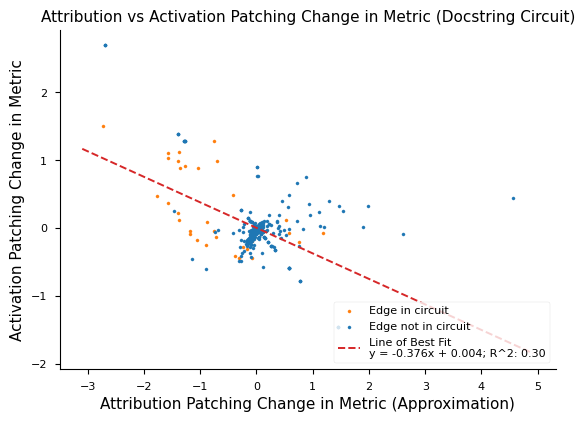

In [13]:
from sklearn.linear_model import LinearRegression
acdc_attrs = []
acdcpp_attrs = []
edge_names = []
is_in_circuit = []

assert sorted(set(acdcpp_scores.keys())) == sorted(set(acdc_scores.keys()))

for acdcpp_edge, acdc_edge in zip(sorted(acdcpp_scores.keys()), sorted(acdc_scores.keys())):
    assert acdcpp_edge == acdc_edge
    acdc_attrs.append(-acdc_scores[acdcpp_edge])
    acdcpp_attrs.append(acdcpp_scores[acdcpp_edge])
    edge_names.append(acdcpp_edge)

    if acdc_edge in true_edges:
        is_in_circuit.append(True)
    else:
        is_in_circuit.append(False)

# Finding line of best fit
linreg = LinearRegression()
linreg.fit(np.array(acdcpp_attrs).reshape(-1, 1), acdc_attrs)
slope = linreg.coef_
intercept = linreg.intercept_
r2 = linreg.score(np.array(acdcpp_attrs).reshape(-1, 1), acdc_attrs)
scatter_df = pd.DataFrame({'acdc_attrs': acdc_attrs, 'acdcpp_attrs': acdcpp_attrs, 'is_in_circuit': is_in_circuit})

ax = plt.gca()
ax.scatter(
    scatter_df[scatter_df['is_in_circuit'] == True]['acdcpp_attrs'],
    scatter_df[scatter_df['is_in_circuit'] == True]['acdc_attrs'],
    marker='o', s=5,c='#ff7f0e', label='Edge in circuit'
)
ax.scatter(
    scatter_df[scatter_df['is_in_circuit'] == False]['acdcpp_attrs'],
    scatter_df[scatter_df['is_in_circuit'] == False]['acdc_attrs'],
    marker='o', s=5,c='#1f77b4', label='Edge not in circuit'
)
x = np.linspace(*ax.get_xlim())
#ax.plot(x, x, linestyle='dashed', label='y = x', color='#2ca02c')
ax.plot(x, (slope * x) + intercept, linestyle='dashed', label=f'Line of Best Fit \ny = {slope[0]:.3f}x + {intercept:.3f}; R^2: {r2:.2f}', color='#d62728')
ax.set_ylabel('Activation Patching Change in Metric', size=11)
ax.set_xlabel('Attribution Patching Change in Metric (Approximation)', size=11)
ax.set_title('Attribution vs Activation Patching Change in Metric (Docstring Circuit)', size=11)
ax.legend(loc='lower right')
plt.savefig('Attrib_vs_Activ_Scores_Docstring.pdf')

In [17]:
import plotly.graph_objects as go

scatter_df = pd.DataFrame({
    'acdc_attrs': acdc_attrs, 
    'acdcpp_attrs': acdcpp_attrs, 
    'is_in_circuit': is_in_circuit,
    'edge_names': edge_names,
})

# Create a scatter plot
fig = go.Figure()

# Add these as labels later
names_of_edges_in_circuit = scatter_df[scatter_df['is_in_circuit'] == True]['edge_names'].values
names_of_edges_not_in_circuit = scatter_df[scatter_df['is_in_circuit'] == False]['edge_names'].values

# Add data for edges in circuit
fig.add_trace(go.Scatter(
    x=scatter_df[scatter_df['is_in_circuit'] == True]['acdcpp_attrs'],
    y=scatter_df[scatter_df['is_in_circuit'] == True]['acdc_attrs'],
    mode='markers',
    marker=dict(color='#ff7f0e'),
    name = 'Edge in circuit',
    text = names_of_edges_in_circuit,

))

# Add data for edges not in circuit
fig.add_trace(go.Scatter(
    x=scatter_df[scatter_df['is_in_circuit'] == False]['acdcpp_attrs'],
    y=scatter_df[scatter_df['is_in_circuit'] == False]['acdc_attrs'],
    mode='markers',
    marker=dict(color='#1f77b4'),
    name = 'Edge not in circuit',
    text = names_of_edges_not_in_circuit,
))

# Add line of best fit
x = np.linspace(min(acdcpp_attrs), max(acdcpp_attrs), 100)
fig.add_trace(go.Scatter(
    x=x,
    y=(slope * x) + intercept,
    mode='lines',
    line=dict(color='#d62728', dash='dash'),
    name=f'Line of Best Fit \ny = {slope[0]:.3f}x + {intercept:.3f}; R^2: {r2:.2f}'
))

# Update layout
fig.update_layout(
    title='Attribution vs Activation Patching Change in Metric (Docstring Circuit)',
    xaxis_title='Attribution Patching Change in Metric (Approximation)',
    yaxis_title='Activation Patching Change in Metric',
    legend_title="Legend"
)

# Show the plot
fig.show()


In [23]:
sum(scatter_df["acdcpp_attrs"].tolist())

-10.185573775048397

In [10]:
linreg = LinearRegression()
linreg.fit(np.array(acdcpp_attrs).reshape(-1, 1), acdc_attrs)
slope = linreg.coef_
intercept = linreg.intercept_
print(f'y = {slope}x + {intercept}')

y = [0.37616644]x + -0.003989774603951379


In [4]:
np.array(acdcpp_attrs).reshape(-1, 1), acdc_attrs

(array([[ 0.14113736],
        [ 0.95794868],
        [-0.2495518 ],
        ...,
        [-0.00215145],
        [ 0.01526865],
        [ 0.01093859]]),
 [0.04641646146774292,
  -0.18803179264068604,
  0.3609340488910675,
  0.022076845169067383,
  0.012193381786346436,
  -0.7665016055107117,
  -0.31937628984451294,
  -0.03291773796081543,
  0.05331796407699585,
  -0.2348315715789795,
  0.48563988506793976,
  -0.01406937837600708,
  0.03814411163330078,
  -0.9008821845054626,
  -0.2559630870819092,
  -0.06338191032409668,
  0.26006218791007996,
  0.26006218791007996,
  0.26006218791007996,
  0.32457733154296875,
  0.32457733154296875,
  0.32457733154296875,
  -0.10929989814758301,
  -0.10929989814758301,
  -0.10929989814758301,
  0.08162051439285278,
  0.08162051439285278,
  0.08162051439285278,
  -0.016237366944551468,
  -0.016237366944551468,
  -0.016237366944551468,
  0.5821439623832703,
  0.5821439623832703,
  0.5821439623832703,
  0.024476170539855957,
  0.024476170539855957,
  0.0

In [27]:
mpl.rcParams["axes.prop_cycle"]

'#1f77b4'
'#ff7f0e'
'#2ca02c'
'#d62728'
'#9467bd'
'#8c564b'
'#e377c2'
'#7f7f7f'
'#bcbd22'
'#17becf'


# ROC Curve

In [20]:
print(np.quantile(acdc_attrs, [0, .1, .25, .5, 0.75, .9, 1]))
print(np.quantile(acdcpp_attrs, [0, .1, .25, .5, 0.75, .9, 1]))

[9.53674316e-07 2.90518999e-04 1.41012669e-03 5.66375256e-03
 2.45390981e-02 1.12315321e-01 2.69374323e+00]
[4.10713255e-07 2.71706440e-04 1.38883424e-03 6.15102192e-03
 2.76244478e-02 1.29648328e-01 4.55413342e+00]


In [32]:
for e, a in acdcpp_scores.items():
    if abs(a) >= 0.001:
        print(e)

blocks.3.hook_resid_post[:]blocks.3.attn.hook_result[:, :, 6]
blocks.3.hook_resid_post[:]blocks.2.attn.hook_result[:, :, 5]
blocks.3.hook_resid_post[:]blocks.3.attn.hook_result[:, :, 0]
blocks.3.hook_resid_post[:]blocks.0.attn.hook_result[:, :, 2]
blocks.3.hook_resid_post[:]blocks.0.attn.hook_result[:, :, 4]
blocks.3.hook_resid_post[:]blocks.2.attn.hook_result[:, :, 4]
blocks.3.hook_resid_post[:]blocks.1.attn.hook_result[:, :, 4]
blocks.3.hook_resid_post[:]blocks.3.attn.hook_result[:, :, 5]
blocks.3.hook_resid_post[:]blocks.3.attn.hook_result[:, :, 1]
blocks.3.hook_resid_post[:]blocks.2.attn.hook_result[:, :, 0]
blocks.3.hook_resid_post[:]blocks.2.attn.hook_result[:, :, 7]
blocks.3.hook_resid_post[:]blocks.3.attn.hook_result[:, :, 4]
blocks.3.hook_resid_post[:]blocks.1.attn.hook_result[:, :, 5]
blocks.3.hook_resid_post[:]blocks.2.attn.hook_result[:, :, 6]
blocks.3.hook_resid_post[:]blocks.1.attn.hook_result[:, :, 3]
blocks.3.hook_resid_post[:]blocks.2.attn.hook_result[:, :, 1]
blocks.3

In [11]:
def edges_after_thresh(thresh, scores, attr_abs=True):
    edges = set()
    for edge, attr in scores.items():
        #print(edge, abs(attr), thresh, abs(attr) >= thresh)
         # If attr < thresh, would've been removed
        if attr_abs:
            attr = abs(attr)
        if attr >= thresh:
            #print(edge)
            edges.add(edge)
    return edges

data = {
    'Threshold': [0],
    'ACDCpp TPR': [1],
    'ACDCpp TNR': [0],
    'ACDCpp FPR': [1],
    'ACDCpp FNR': [0],
    'TPR': [1],
    'TNR': [0],
    'FPR': [1],
    'FNR': [0],
}

# This should be the same as acdcpp_attrs_set, assert just in case
all_edges = set(acdcpp_scores.keys())

for thresh in np.logspace(-3, 1, num=50, base=5):
    data['Threshold'].append(float(thresh))
    # Variables prefixed with pp_ are after ADCDCpp only
    pp_edges = edges_after_thresh(float(thresh), acdcpp_scores)
    edges = edges_after_thresh(float(thresh), acdc_scores)
    
    pp_tp = len(pp_edges.intersection(true_edges))
    pp_tn = len((all_edges - true_edges).intersection(all_edges - pp_edges))
    pp_fp = len(pp_edges - true_edges)
    pp_fn = len(true_edges - pp_edges)

    tp = len(edges.intersection(true_edges))
    tn = len((all_edges - true_edges).intersection(all_edges - edges))
    fp = len(edges - true_edges)
    fn = len(true_edges - edges)

    pp_tpr = pp_tp / (pp_tp + pp_fn)
    pp_tnr = pp_tn / (pp_tn + pp_fp)
    pp_fpr = 1 - pp_tnr
    pp_fnr = 1 - pp_tpr

    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    fpr = 1 - tnr
    fnr = 1 - tpr

    data['ACDCpp TPR'].append(pp_tpr)
    data['ACDCpp TNR'].append(pp_tnr)
    data['ACDCpp FPR'].append(pp_fpr)
    data['ACDCpp FNR'].append(pp_fnr)

    data['TPR'].append(tpr)
    data['TNR'].append(tnr)
    data['FPR'].append(fpr)
    data['FNR'].append(fnr)
df = pd.DataFrame(data)
# Add thresh inf to end of df
row = [np.inf, 0, 1, 0, 1, 0, 1, 0, 1]
df.loc[len(df)] = row

In [12]:
df.head(50)

,Threshold,ACDCpp TPR,ACDCpp TNR,ACDCpp FPR,ACDCpp FNR,TPR,TNR,FPR,FNR
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
1,0.008000,1.000000,0.568245,0.431755,0.000000,1.000000,0.574513,0.425487,0.000000
2,0.009123,1.000000,0.587744,0.412256,0.000000,1.000000,0.603064,0.396936,0.000000
3,0.010404,1.000000,0.609331,0.390669,0.000000,1.000000,0.620474,0.379526,0.000000
4,0.011865,1.000000,0.633705,0.366295,0.000000,1.000000,0.645543,0.354457,0.000000
5,0.013531,1.000000,0.658774,0.341226,0.000000,1.000000,0.667827,0.332173,0.000000
6,0.015431,1.000000,0.676184,0.323816,0.000000,1.000000,0.691504,0.308496,0.000000
7,0.017597,1.000000,0.697075,0.302925,0.000000,1.000000,0.710306,0.289694,0.000000
8,0.020068,1.000000,0.722841,0.277159,0.000000,1.000000,0.731198,0.268802,0.000000
9,0.022885,1.000000,0.743036,0.256964,0.000000,1.000000,0.757660,0.242340,0.000000


In [55]:
df['TPR']

0     1.000000
1     1.000000
2     1.000000
3     1.000000
4     1.000000
5     1.000000
6     1.000000
7     1.000000
8     1.000000
9     1.000000
10    0.945946
11    0.918919
12    0.945946
13    0.837838
14    0.837838
15    0.648649
16    0.270270
17    0.189189
18    0.189189
19    0.189189
20    0.054054
21    0.000000
Name: TPR, dtype: float64

In [13]:
with open('../Automatic-Circuit-Discovery/experiments/results/plots_data/acdc-docstring-docstring_metric-False-0.json', 'r') as f:
    acdc_docstring_metric = json.load(f)
with open('../Automatic-Circuit-Discovery/experiments/results/plots_data/acdc-docstring-kl_div-False-0.json', 'r') as f:
    acdc_kl_metric = json.load(f)

In [14]:
acdc_kl_metric['trained']['random_ablation']['docstring']['kl_div']['ACDC'].keys()

dict_keys(['test_docstring_stefan', 'score', 'test_docstring_metric', 'steps', 'test_kl_div', 'test_nll', 'test_match_nll', 'edge_fpr', 'edge_tpr', 'edge_precision', 'n_edges', 'node_fpr', 'node_tpr', 'node_precision', 'n_nodes'])

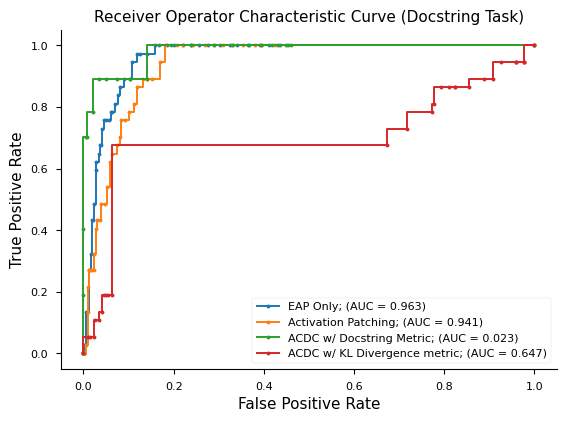

In [15]:
# Calculate AUC using trapezoidal rule
from sklearn.metrics import auc

from scipy import integrate

acdcpp_auc = round(abs(auc(df['ACDCpp FPR'], df['ACDCpp TPR'])), 3)
activ_auc = round(abs(auc(df['FPR'], df['TPR'])), 3)
acdc_docstring_auc = round(
    abs(
        integrate.trapz(
            acdc_docstring_metric['trained']['random_ablation']['docstring']['docstring_metric']['ACDC']['edge_fpr'],
            acdc_docstring_metric['trained']['random_ablation']['docstring']['docstring_metric']['ACDC']['edge_tpr']
        )
    ), 3)
acdc_kl_auc = round(
    abs(
        integrate.trapz(
            acdc_kl_metric['trained']['random_ablation']['docstring']['kl_div']['ACDC']['edge_fpr'],
            acdc_kl_metric['trained']['random_ablation']['docstring']['kl_div']['ACDC']['edge_tpr']
        )
    ), 3)

plt.step(df['ACDCpp FPR'], df['ACDCpp TPR'], marker='.', label=f'EAP Only; (AUC = {acdcpp_auc})')
plt.step(df['FPR'], df['TPR'], marker='.', label=f'Activation Patching; (AUC = {activ_auc})')
plt.step(
    acdc_docstring_metric['trained']['random_ablation']['docstring']['docstring_metric']['ACDC']['edge_fpr'],
    acdc_docstring_metric['trained']['random_ablation']['docstring']['docstring_metric']['ACDC']['edge_tpr'],
    marker='.', 
    label=f'ACDC w/ Docstring Metric; (AUC = {acdc_docstring_auc})'
)
plt.step(
    sorted(acdc_kl_metric['trained']['random_ablation']['docstring']['kl_div']['ACDC']['edge_fpr']),
    sorted(acdc_kl_metric['trained']['random_ablation']['docstring']['kl_div']['ACDC']['edge_tpr']),
    marker='.', 
    label=f'ACDC w/ KL Divergence metric; (AUC = {acdc_kl_auc})'
)
plt.xlabel('False Positive Rate', size=11)
plt.ylabel('True Positive Rate', size=11)
plt.title('Receiver Operator Characteristic Curve (Docstring Task)', size=11)
plt.legend()
plt.savefig('Docstring_ROC_Curve.pdf')

In [92]:
orig_perf['trained']['random_ablation']['docstring']['docstring_metric']['ACDC'].keys()

dict_keys(['steps', 'test_docstring_metric', 'score', 'test_kl_div', 'test_docstring_stefan', 'test_nll', 'test_match_nll', 'edge_fpr', 'edge_tpr', 'edge_precision', 'n_edges', 'node_fpr', 'node_tpr', 'node_precision', 'n_nodes'])

In [94]:
orig_perf['trained']['random_ablation']['docstring']['docstring_metric']['ACDC']['test_nll']

[inf,
 6.28870964050293,
 5.1365556716918945,
 4.315356731414795,
 4.0975165367126465,
 2.9506542682647705,
 2.324460983276367,
 2.0739328861236572,
 1.8339952230453491,
 1.390416145324707,
 1.1645818948745728,
 1.0276647806167603,
 1.0224393606185913,
 1.0109184980392456,
 0.9042666554450989,
 1.0111387968063354,
 0.9957236647605896,
 1.0012856721878052,
 1.0057801008224487,
 1.0577392578125,
 1.0266523361206055,
 1.020729660987854,
 -inf]

In [91]:
df['pp_Youdens_J'] = df['ACDCpp TPR'] - df['ACDCpp FPR']
df['Youdens_J'] = df['TPR'] - df['FPR']
best_threshold_pp = df.loc[df['pp_Youdens_J'].idxmax(), 'Threshold']
best_threshold = df.loc[df['Youdens_J'].idxmax(), 'Threshold']
print(best_threshold_pp, best_threshold)

0.0473844 0.1688318


In [97]:
scores_data = {'attr': [], 'is_in_circuit': []}
for edge, attr in acdcpp_scores.items():
    scores_data['attr'].append(attr)
    if edge in true_edges:
        scores_data['is_in_circuit'].append(True)
    else:
        scores_data['is_in_circuit'].append(False)
        
scores_df = pd.DataFrame(scores_data)

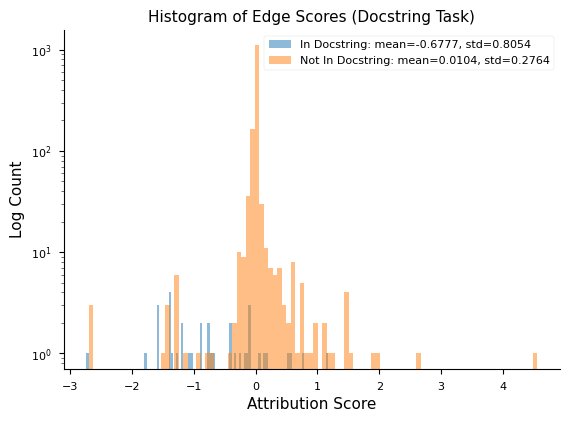

In [119]:
fig, ax = plt.subplots()

# Calculate the mean and standard deviation of scores for positive and negative cases
positive_scores = scores_df[scores_df['is_in_circuit'] == True]['attr']
negative_scores = scores_df[scores_df['is_in_circuit'] == False]['attr']

positive_mean = np.mean(positive_scores)
positive_std = np.std(positive_scores)

negative_mean = np.mean(negative_scores)
negative_std = np.std(negative_scores)


# Plot the distribution of scores for positive and negative cases
ax.hist(positive_scores, 
        bins=100, 
        alpha=0.5, 
        log=True,
        label=f'In Docstring: mean={positive_mean:.4f}, std={positive_std:.4f}')
ax.hist(negative_scores, 
        bins=100, 
        alpha=0.5, 
        log=True,
        label=f'Not In Docstring: mean={negative_mean:.4f}, std={negative_std:.4f}')

# Set the title and labels
ax.set_title('Histogram of Edge Scores (Docstring Task)', size=11)
ax.set_xlabel('Attribution Score', size=11)
ax.set_ylabel('Log Count', size=11)

# Add a legend
ax.legend(loc='upper right')

# Show the plot
plt.show()
fig.savefig('Docstring_Hist_Scores.pdf')